In [1]:
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from neural_ensemble_forecaster import *

In [8]:
class brownian_sampler(object):
    #
    def __init__(self, 
                 initial_value = 0., 
                 time_step = 0.1, 
                 number_time_points = 200, 
                 number_target_points = 100):
        self.initial_value = initial_value
        self.time_step = time_step
        self.number_time_points =  number_time_points
        self.number_target_points = number_target_points
    #
    def __call__(self, batch_size):
        data = np.zeros((batch_size, self.number_time_points - self.number_target_points))
        target = np.zeros((batch_size, self.number_target_points)) 
        for batch_index in range(0,batch_size):
            drift = np.random.normal(0,0.5)
            volatility = np.random.uniform(low = 0.1, high = 3.)
            time_series = np.zeros((self.number_time_points,))
            time_series[0] = self.initial_value
            for time_index in range(0, self.number_time_points - 1):
                time_series[time_index + 1] = (time_series[time_index] 
                                               + self.time_step*drift 
                                               + np.sqrt(self.time_step*volatility)*np.random.normal())
            time_series = time_series - time_series[self.number_time_points - self.number_target_points - 1]
            data[batch_index,:] = time_series[:self.number_time_points - self.number_target_points]
            target[batch_index,:] = time_series[self.number_time_points - self.number_target_points:]
        return [data.astype("float32"), target.astype("float32")]          

(0, 99)

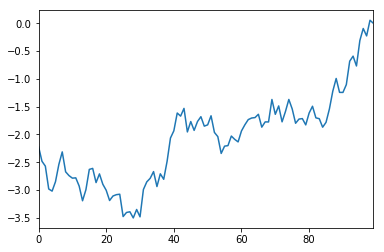

In [9]:
bm_sampler = brownian_sampler()
data_time = range(0,100)
target_time = range(0,100)
data, target = bm_sampler(1)
plt.plot(data_time, data.flatten())
plt.xlim(min(data_time),max(data_time))

In [10]:
network_parameters = {"number_features": 10,
                      "receptive_fields_size": 50,
                      "number_hidden_units": 100,
                      "number_target_time_points": 100}
kernels_parameters = {"number_output_kernels": 3,
                      "minimal_scale": 0.01,
                      "scale_step": 0.05}
center_points_parameters = {"initial_data_size": 100}
bm_forecaster = neural_ensemble_forecaster(network_parameters, 
                                           kernels_parameters, 
                                           center_points_parameters,
                                           bm_sampler)

Number of convolutional layers: 5
Number of linear layers: 1
Number of output links: 300
total number of links: 306


In [12]:
bm_forecaster.train_network(batch_size=500,n_epochs=10)

Training set loss: 251.68746875
Training set loss: 251.53684375
Training set loss: 251.561838281
Training set loss: 250.907630414
Training set loss: 250.815203917


[251.68746874999999,
 251.53684375,
 251.56183828125,
 250.90763041406251,
 250.81520391664066]

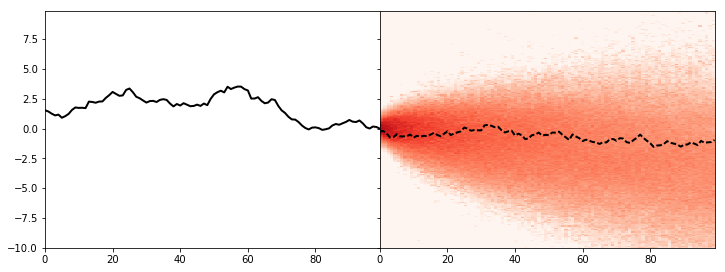

In [13]:
data, target = bm_sampler(1)
output_range = np.arange(-10,10,0.1)
bm_forecaster.visualize_forecast(data_time, data, target_time, output_range, target = target)

In [25]:
class lorentz_sampler(object):
    #
    def __init__(self, sigma = 10, beta =8./3., rho = 28., total_time = np.linspace(0, 4, 200)):
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
        self.total_time = total_time
    #
    def __call__(self, batch_size):
        # dynamics
        def lorentz_deriv((x, y, z), t0, sigma=self.sigma, beta=self.beta, rho=self.rho):
            """Compute the time-derivative of a Lorenz system."""
            return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
        # initial condition
        from scipy import integrate
        x0 = -15 + 30 * np.random.random((batch_size, 3))
        # Solve for the trajectories
        t = np.linspace(0, 4, 200)
        x_t = np.asarray([integrate.odeint(lorentz_deriv, x0i, t) 
                                                   for x0i in x0]).astype("float32")
        return [x_t[:,:100,0].astype("float32"), x_t[:,100:,0].astype("float32")]  

(0, 99)

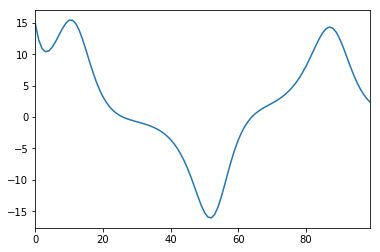

In [30]:
lor_sampler = lorentz_sampler()
data_time = range(0,100)
target_time = range(0,100)
data, target = lor_sampler(1)
plt.plot(data_time, data.flatten())
plt.xlim(min(data_time),max(data_time))

In [57]:
network_parameters = {"number_features": 30,
                      "receptive_fields_size": 50,
                      "number_hidden_units": 100,
                      "number_target_time_points": 100}
kernels_parameters = {"number_output_kernels": 3,
                      "minimal_scale": 0.01,
                      "scale_step": 0.05}
center_points_parameters = {"initial_data_size": 100}
lor_forecaster = neural_ensemble_forecaster(network_parameters, 
                                            kernels_parameters, 
                                            center_points_parameters,
                                            lor_sampler)

Number of convolutional layers: 5
Number of linear layers: 1
Number of output links: 300
total number of links: 306


In [68]:
lor_forecaster.train_network(batch_size=100,n_epochs=10)

Training set loss: 137.299560547
Training set loss: 136.701105469
Training set loss: 136.043107246
Training set loss: 135.812486205
Training set loss: 135.332369588


[137.299560546875,
 136.70110546875,
 136.04310724609377,
 135.81248620527344,
 135.33236958799023]

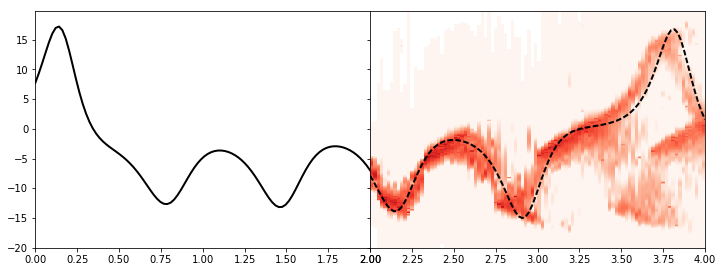

In [69]:
data, target = lor_sampler(1)
data_time = np.linspace(0,2,100)
target_time = np.linspace(2,4,100) 
output_range = np.arange(-20,20,0.1)
lor_forecaster.visualize_forecast(data_time, data, target_time, output_range, target = target)